Parse the profiler output to compare output rows and op times for GPU filter operations.

In [27]:
import csv
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor

profile_dirs = ["/opt/data/profiles/dataproc-gpu-sf100",
                "/opt/data/profiles/dataproc-gpu-sf3k",
                "/opt/data/profiles/dataproc-gpu-sf5k",
                "/opt/data/profiles/dataproc-gpu-sf10k"]

In [28]:
num_scale_factors = len(profile_dirs)
output_rows = [[] for _ in range(num_scale_factors)]
op_times = [[] for _ in range(num_scale_factors)]
for i, profile_dir in enumerate(profile_dirs):
    apps = os.listdir(profile_dir)
    apps.sort()
    for app in apps:
        print(f"Processing gpu profile {profile_dir}/{app}")
        sql_info = pd.read_csv(f"{profile_dir}/{app}/sql_plan_metrics_for_application.csv")
        condition = (sql_info['nodeName'] == 'GpuFilter')
        filtered = sql_info[condition]
        grouped = filtered.groupby("nodeID")
        for _, group in grouped:
            output_rows_for_op = 0
            op_time_for_op = 0
            for row in group.itertuples():
                if row.name == "output rows":
                    output_rows_for_op = row.total
                elif row.name == "op time":
                    op_time_for_op = row.total / 1000000.
            if output_rows_for_op != 0 and op_time_for_op != 0:
                output_rows[i].append(output_rows_for_op)
                op_times[i].append(op_time_for_op)
print([len(x) for x in output_rows])
print([len(x) for x in op_times])

Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0404
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0405
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0406
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0407
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0408
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0409
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0410
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0411
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0412
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0413
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268

1.4709247644634884e-06 119.92940531918285


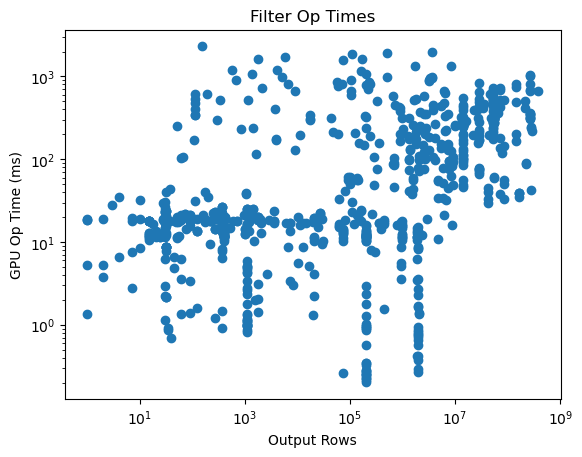

8.036579569965154e-07 305.7731308249748


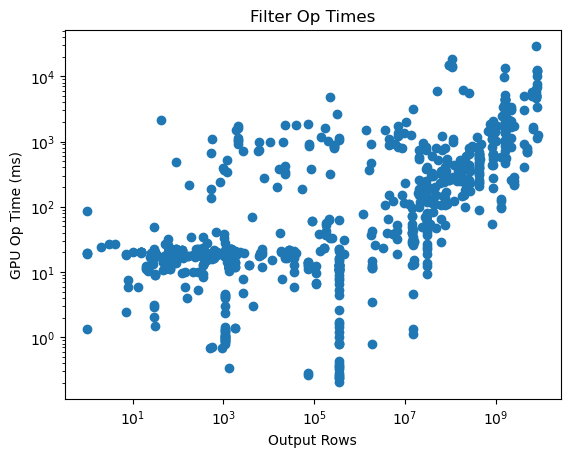

6.63898026704238e-07 470.2852260032157


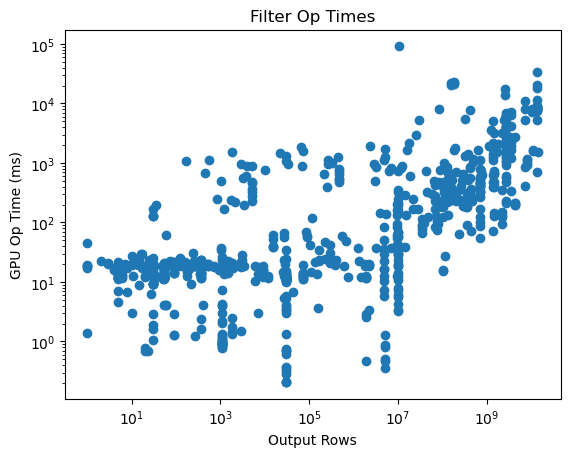

5.76372066094801e-07 1718.3680090905277


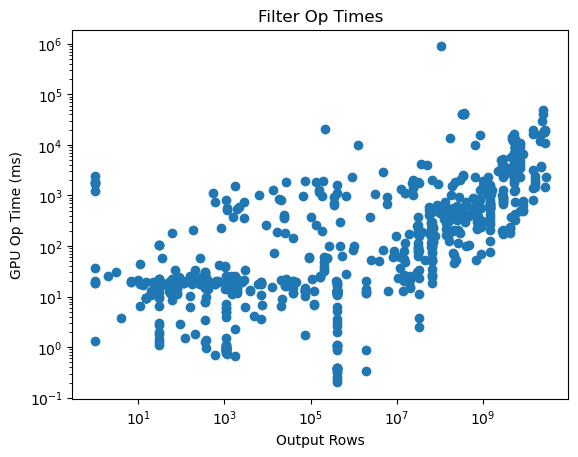

In [29]:
for i in range(num_scale_factors):
    # Create a scatter plot
    plt.scatter(output_rows[i], op_times[i])
    plt.xscale('log')
    plt.yscale('log')
    
    # Calculate the linear regression line
    slope, intercept = np.polyfit(output_rows[i], op_times[i], 1)
    # X = np.array(cpu_times).reshape(-1, 1)
    # y = np.array(gpu_times)
    # regressor = HuberRegressor()
    # regressor.fit(X, y)
    # slope = regressor.coef_[0]
    # intercept = regressor.intercept_
    print(slope, intercept)
    regression_line = np.array(output_rows[i]) * slope + intercept
    
    # Plot the linear regression line
    # plt.plot(output_rows[i], regression_line, color='red')  # you can choose any color you like for the line
    
    # Adding title and labels (optional)
    plt.title("Filter Op Times")
    plt.xlabel("Output Rows")
    plt.ylabel("GPU Op Time (ms)")
    
    # Show the plot
    plt.show()